In [1]:
from ipyleaflet import (Map, GeoData, basemaps, WidgetControl, GeoJSON,
                        LayersControl, Icon, Marker,basemap_to_tiles, Choropleth,
                        MarkerCluster, Heatmap,SearchControl, 
                        FullScreenControl)

from ipywidgets import Text, HTML
from branca.colormap import linear
import geopandas as gpd
import pandas as pd
import json
from dotenv import load_dotenv
load_dotenv()
import requests
from requests.auth import HTTPBasicAuth
import os
from shapely.geometry import Point
from geopandas.tools import sjoin
from shapely.geometry import Point, LineString, Polygon
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
url = os.getenv('COUCHDB_URL')+"/bike_locations/_design/datetime_doc/_view/datetime-index?limit=50000&include_docs=true&descending=true"

payload={}
response = requests.get(url, data=payload, auth=HTTPBasicAuth(os.getenv('COUCHDB_USER'), os.getenv('COUCHDB_PASSWORD')))

data = [row['doc'] for row in response.json()['rows']]
for d in data:
    d.pop('_id', None)
    d.pop('_rev', None)
bike_locations_df = pd.DataFrame(data)
bike_locations=gpd.GeoDataFrame(bike_locations_df, crs=4326, geometry=gpd.points_from_xy(bike_locations_df.lon, bike_locations_df.lat))
bike_locations.drop(columns=['lat', 'lon'],inplace=True)
print(len(bike_locations.index))
bike_locations.head()

50000


,id,datetime,geometry
0,YBO:Vehicle:f343c72e-7c48-49ac-b9fb-3d27eb1ab5d5,2021-12-28T21:15:13.889Z,POINT (10.76100 59.91022)
1,YTI:Vehicle:2841e6a304a3e2b88dd8eb221ce1a0e196...,2021-12-28T21:15:13.887Z,POINT (10.49328 59.89643)
2,YBO:Vehicle:6a6d7e41-df2f-4f21-afd3-46376a5ef75f,2021-12-28T21:15:13.886Z,POINT (10.71480 59.91325)
3,YVO:Vehicle:3f9907c2-5891-4ffa-af1b-06a0e8463ee5,2021-12-28T21:15:13.884Z,POINT (10.69155 59.92304)
4,YBO:Vehicle:81349890-caa6-4330-a0d1-7fe317f1b326,2021-12-28T21:15:13.882Z,POINT (10.75003 59.92817)


In [3]:
#Removing points only mentioned once
bike_locations=bike_locations[bike_locations.groupby('id').id.transform('count') > 1]
print('Number of bikes with mutible points:',bike_locations.shape[0])
bike_locations.head()

Number of bikes with mutible points: 49998


,id,datetime,geometry
0,YBO:Vehicle:f343c72e-7c48-49ac-b9fb-3d27eb1ab5d5,2021-12-28T21:15:13.889Z,POINT (10.76100 59.91022)
1,YTI:Vehicle:2841e6a304a3e2b88dd8eb221ce1a0e196...,2021-12-28T21:15:13.887Z,POINT (10.49328 59.89643)
2,YBO:Vehicle:6a6d7e41-df2f-4f21-afd3-46376a5ef75f,2021-12-28T21:15:13.886Z,POINT (10.71480 59.91325)
3,YVO:Vehicle:3f9907c2-5891-4ffa-af1b-06a0e8463ee5,2021-12-28T21:15:13.884Z,POINT (10.69155 59.92304)
4,YBO:Vehicle:81349890-caa6-4330-a0d1-7fe317f1b326,2021-12-28T21:15:13.882Z,POINT (10.75003 59.92817)


In [4]:
# get top 5 most used bikes names
n = 5
bike_locations['id'].value_counts()[:n].index.tolist()


['YBO:Vehicle:f343c72e-7c48-49ac-b9fb-3d27eb1ab5d5',
 'YVO:Vehicle:8f7e0299-14a1-4b9f-8f2e-408346881359',
 'YVO:Vehicle:cbe71445-70c8-4b6a-9cc0-c20943d48148',
 'YLI:Vehicle:LL3KDVFRBISSC',
 'YVO:Vehicle:8e01e834-715b-45ac-ad73-5db35d283334']

In [5]:
#inspired by: https://pygis.io/docs/e_new_vectors.html 
lines = bike_locations.to_crs(epsg=3857).groupby(['id'])['geometry'].apply(lambda x:  LineString(x.tolist()))#LineString(x.tolist())
lines.head()

id
YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923    LINESTRING (1198272.293 8385155.408, 1198278.3...
YBO:Vehicle:01d9a716-87f0-4245-9b62-a0624bd0a43a    LINESTRING (1198625.708 8381642.010, 1198616.6...
YBO:Vehicle:01f09a4b-1bfd-4042-94f4-a9b3778c7794    LINESTRING (1194597.052 8383182.411, 1194591.0...
YBO:Vehicle:021cdfd7-c0fc-4d70-b85d-aecf28d99b5a    LINESTRING (1192290.777 8384031.549, 1192302.6...
YBO:Vehicle:033611de-c121-4956-a9dc-49dd4748c421    LINESTRING (1191315.568 8381892.790, 1191315.2...
Name: geometry, dtype: geometry

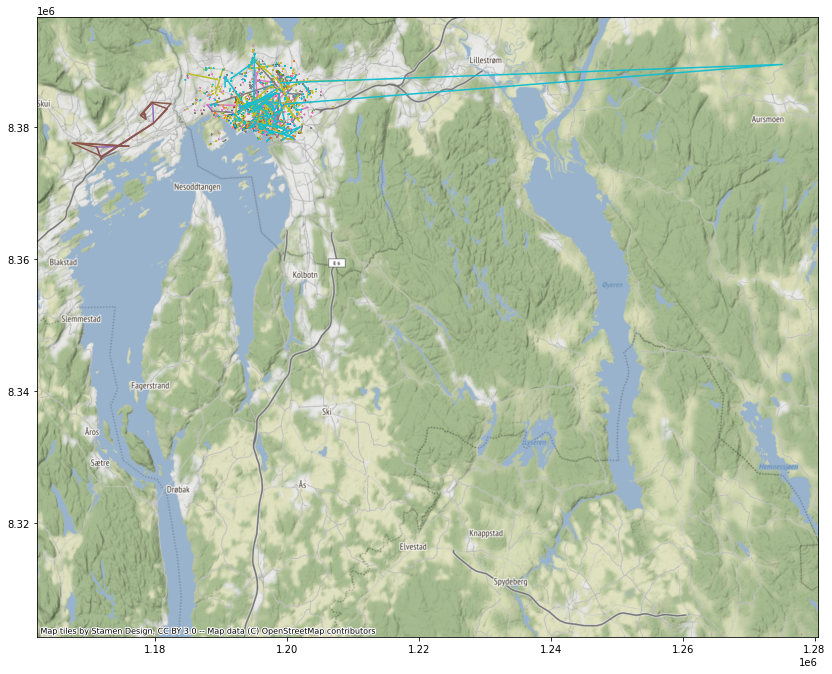

In [6]:
# store as a GeodataFrame and add 'ID' as a column (currently stored as the 'index')
lines = gpd.GeoDataFrame(lines, geometry='geometry', crs="EPSG:3857") 
lines.reset_index(inplace=True)
f, ax1 = plt.subplots(1, figsize=(14, 14))
ax1=lines.plot(column='id',ax=ax1)
cx.add_basemap(ax1)

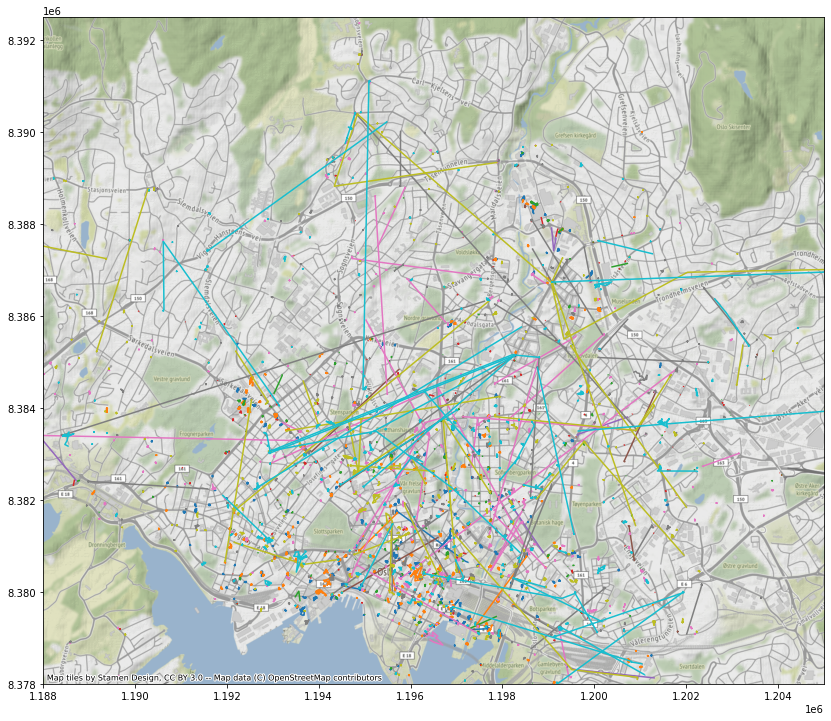

In [7]:
# store as a GeodataFrame and add 'ID' as a column (currently stored as the 'index')
f, ax3 = plt.subplots(1, figsize=(14, 14))
ax3=lines.plot(column='id',ax=ax3)
ax3.set_xlim(1190000-2000, 1195000+10000)
ax3.set_ylim(8380000-2000, 8382500+10000)
cx.add_basemap(ax3)


In [9]:
bike_locations_sorted=bike_locations.sort_values(by=['id','datetime'])
bike_locations_sorted=bike_locations_sorted.to_crs(epsg=5234)
bike_locations_sorted.head()

,id,datetime,geometry
48691,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-28T17:30:06.791Z,POINT (-3067550.968 8177945.043)
45630,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-28T17:45:06.825Z,POINT (-3067550.267 8177945.862)
42568,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-28T18:00:06.830Z,POINT (-3067548.021 8177940.514)
39503,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-28T18:15:07.051Z,POINT (-3067548.792 8177941.108)
36439,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-28T18:30:07.606Z,POINT (-3067550.217 8177938.281)


In [10]:
new_table = [] 
for name, group in bike_locations_sorted.groupby('id',sort=True):
    group.to_crs(epsg=5234,inplace=True)
    group["meters_to_next_point"]=group.distance(group.shift(-1))
    group.to_crs(epsg=3857,inplace=True)
    group['from']=group['geometry']
    group['to']=group.shift(-1)['geometry']
    group['datetime_from']=group['datetime']
    group['datetime_to']=group.shift(-1)['datetime']
    d.pop('datetime', None)
    group.drop(group.tail(1).index,inplace=True)
    group1 = group.copy()
    if len(new_table)==0:
        new_table = [group1]
    else:
        new_table.append(group1)

        
        
movements = pd.concat(new_table).reset_index(drop=True)
movements['geometry'] = movements.apply(lambda row: LineString([row['from'], row['to']]), axis=1) #Create a linestring column
movements.head()



/Users/hakon/opt/anaconda3/envs/location-data-cleaner/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,id,datetime,geometry,meters_to_next_point,from,to,datetime_from,datetime_to
0,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-28T17:30:06.791Z,"LINESTRING (1198277.648 8385150.353, 1198276.7...",1.077644,POINT (1198277.648 8385150.353),POINT (1198276.799 8385152.049),2021-12-28T17:30:06.791Z,2021-12-28T17:45:06.825Z
1,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-28T17:45:06.825Z,"LINESTRING (1198276.799 8385152.049, 1198286.9...",5.800234,POINT (1198276.799 8385152.049),POINT (1198286.991 8385152.049),2021-12-28T17:45:06.825Z,2021-12-28T18:00:06.830Z
2,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-28T18:00:06.830Z,"LINESTRING (1198286.991 8385152.049, 1198285.5...",0.973351,POINT (1198286.991 8385152.049),POINT (1198285.504 8385151.201),2021-12-28T18:00:06.830Z,2021-12-28T18:15:07.051Z
3,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-28T18:15:07.051Z,"LINESTRING (1198285.504 8385151.201, 1198289.1...",3.165119,POINT (1198285.504 8385151.201),POINT (1198289.114 8385146.963),2021-12-28T18:15:07.051Z,2021-12-28T18:30:07.606Z
4,YBO:Vehicle:01593162-0b8c-4e08-baf0-d75efbe49923,2021-12-28T18:30:07.606Z,"LINESTRING (1198289.114 8385146.963, 1198297.9...",5.014789,POINT (1198289.114 8385146.963),POINT (1198297.925 8385146.963),2021-12-28T18:30:07.606Z,2021-12-28T18:45:06.851Z


array([[<AxesSubplot:title={'center':'meters_to_next_point'}>]],
      dtype=object)

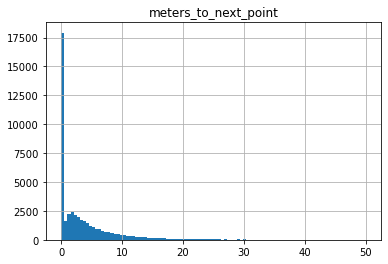

In [13]:
#Looking at distanses shorter than 50m
movements.hist(column='meters_to_next_point',bins=list(np.linspace(0, 50, num=100)))

array([[<AxesSubplot:title={'center':'meters_to_next_point'}>]],
      dtype=object)

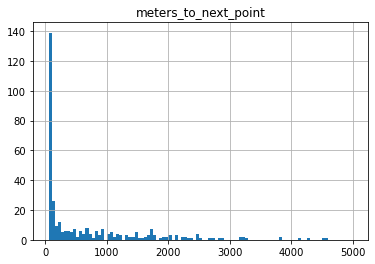

In [19]:
#Lookign at distanses over 50m
movements.hist(column='meters_to_next_point',bins=list(np.linspace(50, 5000, num=100)))

In [20]:



trips=movements[movements['meters_to_next_point']>100]
trips.head(10)

,id,datetime,geometry,meters_to_next_point,from,to,datetime_from,datetime_to
312,YBO:Vehicle:0b7232a4-096a-4448-b196-3acf0be2cd99,2021-12-28T19:30:10.461Z,"LINESTRING (1196818.020 8381176.086, 1196616.7...",180.331514,POINT (1196818.020 8381176.086),POINT (1196616.735 8380931.260),2021-12-28T19:30:10.461Z,2021-12-28T19:45:10.446Z
313,YBO:Vehicle:0b7232a4-096a-4448-b196-3acf0be2cd99,2021-12-28T19:45:10.446Z,"LINESTRING (1196616.735 8380931.260, 1196883.0...",225.719200,POINT (1196616.735 8380931.260),POINT (1196883.097 8381225.222),2021-12-28T19:45:10.446Z,2021-12-28T20:00:10.629Z
507,YBO:Vehicle:10b559d4-2bd7-4d18-b739-e308204c4fe7,2021-12-28T19:00:07.348Z,"LINESTRING (1197981.986 8379094.052, 1197910.3...",108.191742,POINT (1197981.986 8379094.052),POINT (1197910.326 8378917.894),2021-12-28T19:00:07.348Z,2021-12-28T19:15:08.541Z
508,YBO:Vehicle:10b559d4-2bd7-4d18-b739-e308204c4fe7,2021-12-28T19:15:08.541Z,"LINESTRING (1197910.326 8378917.894, 1197940.6...",111.656711,POINT (1197910.326 8378917.894),POINT (1197940.688 8379111.838),2021-12-28T19:15:08.541Z,2021-12-28T19:30:06.653Z
2237,YBO:Vehicle:397e6d3f-6fc7-4d1f-a9af-a71243e6db9b,2021-12-28T20:15:08.848Z,"LINESTRING (1195702.570 8381758.110, 1197193.5...",1051.906342,POINT (1195702.570 8381758.110),POINT (1197193.517 8380666.111),2021-12-28T20:15:08.848Z,2021-12-28T20:45:11.629Z
2754,YBO:Vehicle:47382c69-a861-41af-8682-025b71cf711c,2021-12-28T20:00:06.424Z,"LINESTRING (1196887.662 8379639.492, 1197048.4...",142.287719,POINT (1196887.662 8379639.492),POINT (1197048.498 8379830.913),2021-12-28T20:00:06.424Z,2021-12-28T20:15:06.365Z
2755,YBO:Vehicle:47382c69-a861-41af-8682-025b71cf711c,2021-12-28T20:15:06.365Z,"LINESTRING (1197048.498 8379830.913, 1196915.3...",127.199324,POINT (1197048.498 8379830.913),POINT (1196915.371 8379651.350),2021-12-28T20:15:06.365Z,2021-12-28T20:30:06.345Z
2982,YBO:Vehicle:4e4549a4-caae-4775-a54b-a2e87f829ae5,2021-12-28T19:45:08.898Z,"LINESTRING (1194523.104 8380131.608, 1194895.6...",216.401937,POINT (1194523.104 8380131.608),POINT (1194895.628 8380057.068),2021-12-28T19:45:08.898Z,2021-12-28T20:00:09.073Z
3152,YBO:Vehicle:51ecb0bc-711a-41d1-b4b5-b4eba0d9f3e5,2021-12-28T20:00:10.792Z,"LINESTRING (1197723.692 8379199.919, 1197320.4...",229.957076,POINT (1197723.692 8379199.919),POINT (1197320.487 8379181.286),2021-12-28T20:00:10.792Z,2021-12-28T20:15:10.552Z
4945,YBO:Vehicle:7bd78067-316d-4994-a874-cc51cf51034b,2021-12-28T19:00:06.595Z,"LINESTRING (1195573.795 8380493.304, 1195668.5...",265.660316,POINT (1195573.795 8380493.304),POINT (1195668.598 8380035.892),2021-12-28T19:00:06.595Z,2021-12-28T19:30:09.676Z


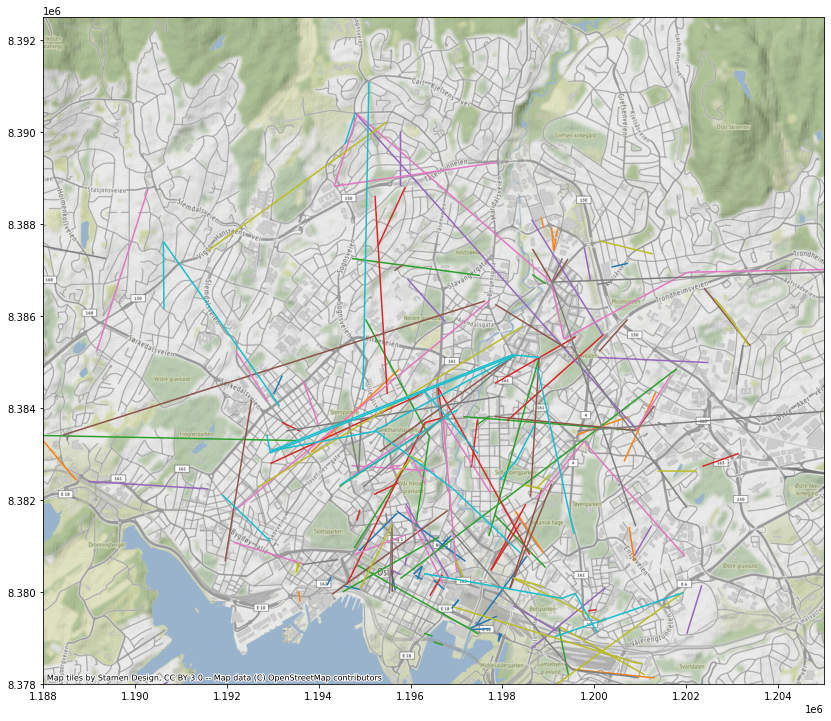

In [17]:
# store as a GeodataFrame and add 'ID' as a column (currently stored as the 'index')
f, ax5 = plt.subplots(1, figsize=(14, 14))
ax5=trips.plot(column='id',ax=ax5)
ax5.set_xlim(1190000-2000, 1195000+10000)
ax5.set_ylim(8380000-2000, 8382500+10000)
cx.add_basemap(ax5)